# 06wk-1: 합성곱신경망 (2) – MNIST, Fashion MNIST, ImageNet, CIFAR10

최규빈  
2024-04-08

<a href="https://colab.research.google.com/github/guebin/DL2024/blob/main/posts/06wk-1.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

<https://youtu.be/playlist?list=PLQqh36zP38-wTzMRmZzvr2TL12DNo6jXF&si=RnG6_-uhn9Yb57nU>

# 2. Imports

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import pandas as pd
from fastai.data.all import *
from fastai.vision.all import *

# 3. torch.eigensum

## A. transpose

In [ ]:
tsr = torch.arange(12).reshape(4,3)
tsr

tensor([[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11]])

In [ ]:
tsr.t() #transpose

tensor([[ 0,  3,  6,  9],
        [ 1,  4,  7, 10],
        [ 2,  5,  8, 11]])

In [ ]:
torch.einsum('ij->ji',tsr) #개쳐돌았다 .. 근데 개별로 같은데 라고 했던 내자신을 욕하고싶네요

tensor([[ 0,  3,  6,  9],
        [ 1,  4,  7, 10],
        [ 2,  5,  8, 11]])

## B. 행렬곱

In [ ]:
tsr1 = torch.arange(12).reshape(4,3).float()
tsr2 = torch.arange(15).reshape(3,5).float()

In [ ]:
tsr1.shape

torch.Size([4, 3])

In [ ]:
tsr2.shape

torch.Size([3, 5])

In [ ]:
tsr1 @ tsr2 #행렬곱 연산

tensor([[ 25.,  28.,  31.,  34.,  37.],
        [ 70.,  82.,  94., 106., 118.],
        [115., 136., 157., 178., 199.],
        [160., 190., 220., 250., 280.]])

In [ ]:
torch.einsum('ij,jk -> ik',tsr1,tsr2)  #dimension의 인덱스를 통한 행렬곱 연산..

tensor([[ 25.,  28.,  31.,  34.,  37.],
        [ 70.,  82.,  94., 106., 118.],
        [115., 136., 157., 178., 199.],
        [160., 190., 220., 250., 280.]])

쓸모 개없어 보이는데.. 다음을 보면 쓸모가 있어질 수도..?


## C. 이미지변환

In [ ]:
r = torch.zeros(16).reshape(4,4) + 1.0
g = torch.zeros(16).reshape(4,4)
b = torch.zeros(16).reshape(4,4)
img_plt = torch.stack([r,g,b],axis=-1) #matplotlib 를 쓰기 위해서는 이미지가 이렇게 저장되어있어야한다.
img_torch = torch.stack([r,g,b],axis=0).reshape(1,3,4,4) # torch를 쓰기 위해서는 이미지가 이렇게 저장되어있어야한다.

In [ ]:
img_plt.shape, img_torch.shape

(torch.Size([4, 4, 3]), torch.Size([1, 3, 4, 4]))

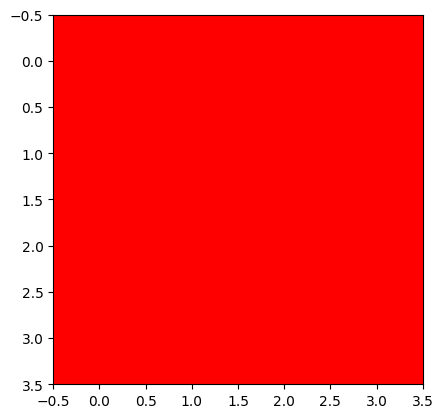

In [ ]:
plt.imshow(img_plt)

만약에 `img_torch`를 matplotlib 으로 보고싶다면?

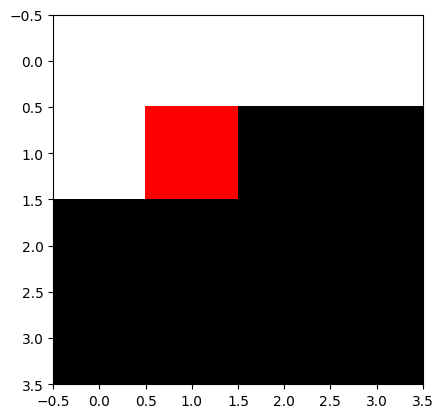

In [ ]:
# 잘못된코드
plt.imshow(img_torch.reshape(4,4,3)) #뭔가 우리의 의도대로 변환이 되지 않은 것 같다.

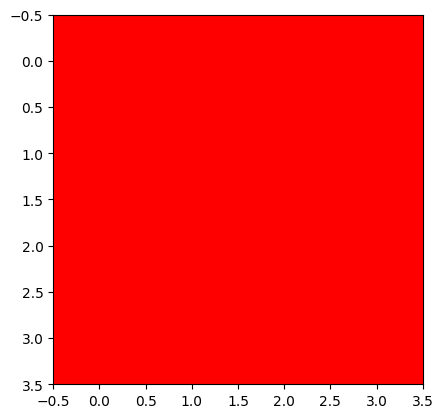

In [ ]:
plt.imshow(torch.einsum('hijk -> jki',img_torch)) #ㅎㅎ 내가 만든 코드

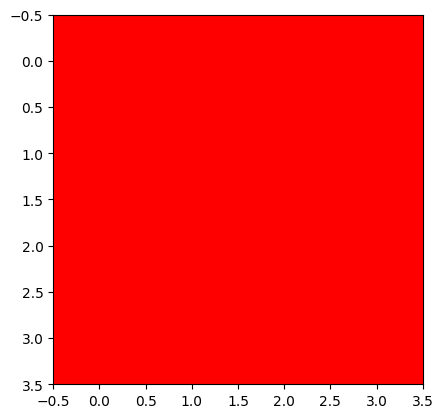

In [ ]:
# 올바른코드
plt.imshow(torch.einsum('ocij -> ijc',img_torch)) #이건 좀 인정..

# 4. MNIST – 직접설계

In [ ]:
path = untar_data(URLs.MNIST)
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/1').ls()])
X2 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'training/2').ls()])
X = torch.concat([X0,X1,X2])/255
y = torch.nn.functional.one_hot(torch.tensor([0]*len(X0) + [1]*len(X1) + [2]*len(X2))).float()
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/0').ls()])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/1').ls()])
X2 = torch.stack([torchvision.io.read_image(str(fname)) for fname in (path/'testing/2').ls()])
XX = torch.concat([X0,X1,X2])/255
yy = torch.nn.functional.one_hot(torch.tensor([0]*len(X0) + [1]*len(X1) + [2]*len(X2))).float()

In [ ]:
print(X.shape,'\t',X.dtype) #흑백
print(y.shape,'\t\t\t',y.dtype) #원핫 인코딩..
print(XX.shape,'\t',XX.dtype)
print(yy.shape,'\t\t\t',yy.dtype)

torch.Size([18623, 1, 28, 28]) 	 torch.float32
torch.Size([18623, 3]) 			 torch.float32
torch.Size([3147, 1, 28, 28]) 	 torch.float32
torch.Size([3147, 3]) 			 torch.float32


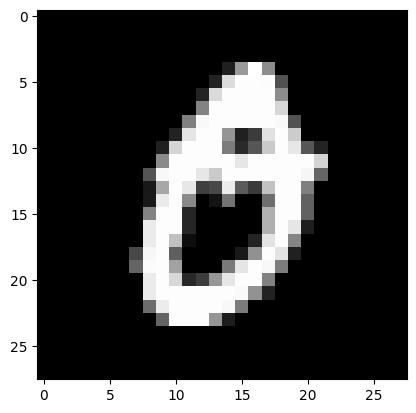

In [ ]:
plt.imshow(torch.einsum('cij -> ijc',X[0]),cmap="gray") #좌표 돌리는것 가까워지기

## A. y: (n,3)-float

In [ ]:
# Step1: 데이터정리 (dls생성) #gpu를 이용해서 학습할 땐 ds와 dl을 사용하기
ds = torch.utils.data.TensorDataset(X,y) #신기한 방식으로 인덱스를 받음.
dl = torch.utils.data.DataLoader(ds,batch_size=128) #for문을 돌리기 위한 오브젝트
# Step2: 적합에 필요한 오브젝트 생성
net1 = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)), #(5,5)는 커널 사이즈~ feature 1 -> 16 뻥튀기
    torch.nn.ReLU(), #activation
    torch.nn.MaxPool2d((2,2)), #요약!
    torch.nn.Flatten() #reshape(-1,16* 뭐시기로 직접 찾아야 하는데.. Flatten은 그냥 써버리면 됨.. ) 앞으로 Flatten 쓰자..
) #네트워크에 X[[0]] 집어 넣으면 1,2034가 나옴.. 그래서 2304로 이어받는것..
net2 = torch.nn.Sequential(
    torch.nn.Linear(2304,3), #원핫 인코딩으로 사이즈 맞추기, 3개의 클래스
)
net = torch.nn.Sequential(
    net1, # 2d-part
    net2, # 1d-part
)
loss_fn = torch.nn.CrossEntropyLoss() #softmax function이 포함되어 있슴둥..
optimizr = torch.optim.Adam(net.parameters()) #국민 옵티마이저 Adam
# Step3: 적합
net.to("cuda:0")
for epoc in range(10): #에폭을 바꾸면서 관찰하면 좀 더 공부에 용이할 듯!
    for xi,yi in dl:
        ## 1
        ## 2
        loss = loss_fn(net(xi.to("cuda:0")),yi.to("cuda:0"))
        ## 3
        loss.backward()
        ## 4
        optimizr.step()
        optimizr.zero_grad()
net.to("cpu")
# Step4: 예측 및 평가
print(f'train: {(net(X).data.argmax(axis=1) == y.argmax(axis=1)).float().mean():.4f}')
print(f'val: {(net(XX).data.argmax(axis=1) == yy.argmax(axis=1)).float().mean():.4f}')

train: 0.9819
val: 0.9886


직접 찍어보는 연습 해야해~

## B. y: (n,)-int , 즉 원핫 인코딩을 하지 않고 그냥 벡터로 보겠다.

In [ ]:
y = y.argmax(axis=-1)
yy = yy.argmax(axis=-1)
y,yy

(tensor([0, 0, 0,  ..., 2, 2, 2]), tensor([0, 0, 0,  ..., 2, 2, 2]))

In [ ]:
print(X.shape,'\t',X.dtype)
print(y.shape,'\t\t',y.dtype) #원핫 인코딩을 안하면 정수로 받는 것인가? 이건 자동으로 원핫 인코딩 시킬거라서 라벨을 뜻하면 int로 해야함
print(XX.shape,'\t',XX.dtype)
print(yy.shape,'\t\t',yy.dtype)

torch.Size([18623, 1, 28, 28]) 	 torch.float32
torch.Size([18623]) 		 torch.int64
torch.Size([3147, 1, 28, 28]) 	 torch.float32
torch.Size([3147]) 		 torch.int64


이거 다시 하기.. 실수로 아래부터 돌려버림.

In [ ]:
# Step1: 데이터정리 (dls생성)
ds = torch.utils.data.TensorDataset(X,y)
dl = torch.utils.data.DataLoader(ds,batch_size=128)
# Step2: 적합에 필요한 오브젝트 생성
net1 = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten()
)
net2 = torch.nn.Sequential(
    torch.nn.Linear(2304,3),
)
net = torch.nn.Sequential(
    net1, # 2d-part
    net2, # 1d-part
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())
# Step3: 적합
net.to("cuda:0")
for epoc in range(10):
    for xi,yi in dl:
        ## 1
        ## 2
        loss = loss_fn(net(xi.to("cuda:0")),yi.to("cuda:0"))
        ## 3
        loss.backward()
        ## 4
        optimizr.step()
        optimizr.zero_grad()
net.to("cpu")
# Step4: 예측 및 평가
print(f'train: {(net(X).data.argmax(axis=1) == y).float().mean():.4f}') # <-- 여기수정 마지막에 :.4f는 소숫점 조절.
print(f'val: {(net(XX).data.argmax(axis=1) == yy).float().mean():.4f}') # <-- 테스트 보다도.. 학습이 잘 되어가는지 체크하는 과정이므로 validation이 맞을듯.

train: 0.9838
val: 0.9901


# 5. Fashion-MNIST – fastai

`-` Data

In [ ]:
df_train=pd.read_csv('https://media.githubusercontent.com/media/guebin/PP2023/main/posts/fashion-mnist_train.csv')
df_test=pd.read_csv('https://media.githubusercontent.com/media/guebin/PP2023/main/posts/fashion-mnist_test.csv')
def rshp(row):
    return row.reshape(1,28,28)
X = torch.tensor(np.apply_along_axis(rshp,axis=1,arr=np.array(df_train.iloc[:,1:]))).float()
XX  = torch.tensor(np.apply_along_axis(rshp,axis=1,arr=np.array(df_test.iloc[:,1:]))).float()
y = torch.tensor(np.array(df_train.label))
yy  = torch.tensor(np.array(df_test.label))

In [ ]:
print(X.shape,'\t',X.dtype)
print(y.shape,'\t\t\t',y.dtype) #이 벡터가 클래스를 나타내는 벡터임을 컴퓨터에게 알리려면 int여야함..(자동 원핫 인코딩)
#float으로 들어가면 그렇게 인식을 안해줌
#손수 원핫인코딩 할거면 float으로 잡아줘야함.
print(XX.shape,'\t',XX.dtype)
print(yy.shape,'\t\t\t',yy.dtype)

torch.Size([60000, 1, 28, 28]) 	 torch.float32
torch.Size([60000]) 			 torch.int64
torch.Size([10000, 1, 28, 28]) 	 torch.float32
torch.Size([10000]) 			 torch.int64


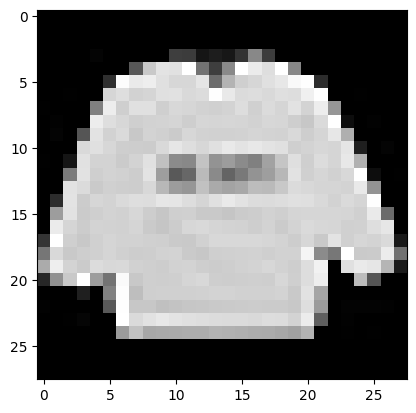

In [ ]:
plt.imshow(torch.einsum('cij -> ijc',X[0]),cmap="gray") #토치 시각화를 위한 데이터를 맷플롯으로 시각화하기 위해..

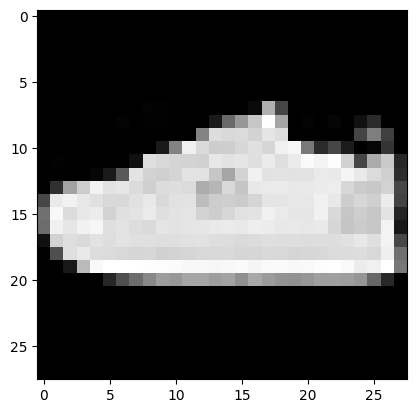

In [ ]:
plt.imshow(torch.einsum('cij -> ijc',X[-1]),cmap="gray")

테스트 데이터셋이 어떻게 되어있는지 잘 보는것도 중요.. 난 근데 int 벡터 형태가 좋다.

## A. torch

In [ ]:
# Step1: 데이터정리 (dls생성)
ds = torch.utils.data.TensorDataset(X,y)
dl = torch.utils.data.DataLoader(ds,batch_size=128)
# Step2: 적합에 필요한 오브젝트 생성
net1 = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten()
)
net2 = torch.nn.Sequential(
    torch.nn.Linear(2304,10),
)
net = torch.nn.Sequential(
    net1, # 2d-part
    net2, # 1d-part
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())
# Step3: 적합
net.to("cuda:0")
for epoc in range(10):
    for xi,yi in dl:
        ## 1
        ## 2
        loss = loss_fn(net(xi.to("cuda:0")),yi.to("cuda:0"))
        ## 3
        loss.backward()
        ## 4
        optimizr.step()
        optimizr.zero_grad()
net.to("cpu")
# Step4: 예측 및 평가
print(f'train: {(net(X).data.argmax(axis=1) == y).float().mean():.4f}')
print(f'val: {(net(XX).data.argmax(axis=1) == yy).float().mean():.4f}')

train: 0.9099
val: 0.8715


In [ ]:
#여기서 linear로 10개를 걸어줄 생각을 어떻게 했을까요? 즉 라벨이 10개인걸 어떻게 알았느냐..
set(y.tolist()) #리스트로 바꾸고 set을 걸어주면 unique한 원소들만 나옵니다

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

## B. fastai

In [ ]:
# Step1: 데이터정리 (dls생성) #여기서부터 torch랑 좀 다름.. ds 와 dl 객체를 만드는 것 부터 다르다..
ds1 = torch.utils.data.TensorDataset(X,y)
ds2 = torch.utils.data.TensorDataset(XX,yy)
dl1 = torch.utils.data.DataLoader(ds1,batch_size=128)
dl2 = torch.utils.data.DataLoader(ds2,batch_size=5000) #코드 돌아가는 찰나를 보면... 2가 보일것이느니..
dls = DataLoaders(dl1,dl2) #데이터 로더스! 데이터 로더들을 한번에 관리해주는군

#fastai에서는 한번에 다 꾸겨 넣어서 valid loss , training loss를 다 구해줌

# Step2: 적합에 필요한 오브젝트 생성
net1 = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten()
)
net2 = torch.nn.Sequential(
    torch.nn.Linear(2304,10), #이건 첫번째 네트워크로 컨닝 가능..
)
net = torch.nn.Sequential(
    net1, # 2d-part
    net2, # 1d-part
)
loss_fn = torch.nn.CrossEntropyLoss()
#optimizr = torch.optim.Adam(net.parameters())
lrnr = Learner(
    dls=dls,
    model=net,
    loss_func=loss_fn,
    #--#
    metrics=[accuracy] #이게 없으면 학습하면서 accuracy를 보여주지 않음..
) #존나 오랜만에 보는 fastai의 learner 객체..

# Step3: 적합
lrnr.fit(10) #데이터 60000개, 미니배치 사이즈 128개.. 60000/128번 만큼 학습이 돌아야 한번의 에폭이 도는 것임.
# Step4: 예측 및 평가

lrnr.model.to("cpu") #학습기가 cuda에 있었으니 다시 cpu로 끌어냄.. 근데 알아서 GPU로 끌고 올라가주네..? 맞음
print(f'train: {(lrnr.model(X).data.argmax(axis=1) == y).float().mean():.4f}')
print(f'val: {(lrnr.model(XX).data.argmax(axis=1) == yy).float().mean():.4f}')

epoch,train_loss,valid_loss,accuracy,time
0,0.565364,0.505222,0.853900,00:02
1,0.398918,0.442924,0.860300,00:01
2,0.348324,0.422980,0.866000,00:01
3,0.310801,0.422795,0.869800,00:02
4,0.287141,0.448671,0.869200,00:01
5,0.272882,0.466783,0.865400,00:02
6,0.260355,0.475330,0.869100,00:01
7,0.256395,0.490048,0.866500,00:02
8,0.249860,0.494399,0.869200,00:01
9,0.242138,0.512664,0.866100,00:02


train: 0.9143
val: 0.8661


In [ ]:
60000/128 #한 에폭에 미니배치가 469번 만큼 돌아야 함.
#찰나의 2 드립은 validation set이 10000개의 관측치인데 미니배치 사이즈를 5000으로 잡았기 때문..
#발리데이션에선 미니배치가 두번 돌면 한 에폭이 도는 것이다.

468.75

In [ ]:
lrnr.model #우리가 설계한 모델이 들어가 있답니다.

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (1): Sequential(
    (0): Linear(in_features=2304, out_features=10, bias=True)
  )
)

In [ ]:
#list(lrnr.model.parameters()) #이거 optimizer에 넣던 그 문법 그대로임

# 6. ImageNet – 직접설계/transfer

## A. 알렉스넷(Krizhevsky, Sutskever, and Hinton 2012)의 의미

`-` 야사로 배우는 인공지능: <https://brunch.co.kr/@hvnpoet/109>

## B. 알렉스넷의 아키텍처 써보기

`-` 알렉스넷의 아키텍처:

-ref:
<https://en.wikipedia.org/wiki/AlexNet#:~:text=AlexNet%20is%20the%20name%20of,at%20the%20University%20of%20Toronto.>

![](https://upload.wikimedia.org/wikipedia/commons/thumb/c/cc/Comparison_image_neural_networks.svg/960px-Comparison_image_neural_networks.svg.png)

`-` 재미삼아 써보면..

In [ ]:
img = torch.zeros(1,3*224*224).reshape(1,3,224,224) #토치 스타일.
img.shape

torch.Size([1, 3, 224, 224])

In [ ]:
conv = torch.nn.Conv2d(3,96,kernel_size = (11,11),stride = 4 )
conv(img).shape #우리가 보고자 하는 대로 나옴ㅋ.

torch.Size([1, 96, 54, 54])

In [ ]:
mp = torch.nn.MaxPool2d(kernel_size = (3,3),stride = 2) #커널 사이즈 만큼 스트라이드를 하는게 디폴트임. 근데 2로 함.
mp(conv(img)).shape

torch.Size([1, 96, 26, 26])

In [ ]:
conv2_ = torch.nn.Conv2d(
        96,256,kernel_size = (5,5)
)
conv2_(mp(conv(img))).shape

torch.Size([1, 256, 22, 22])

In [ ]:
conv2 = torch.nn.Conv2d(
        96,256,kernel_size = (5,5),padding = 2 #더미값 추가.. 맥스 풀 하고 난 다음이랑 conv2를 취한 다음이랑 디멘션이 같음... 유지되는 효과
)
conv2(mp(conv(img))).shape

torch.Size([1, 256, 26, 26])

한번쯤 따지면서 쭉쭉 써보면 패딩에 대한 이해가 좋아질 겁니다~

In [ ]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(3,96,kernel_size=(11,11),stride=4), #stride가 뭐냐.. 원래 컨볼루션은 한칸씩 윈도우를 미는데 4로 설정하면 4칸씩 민다.
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((3,3),stride=2), # default stride는 3
    torch.nn.Conv2d(96,256,kernel_size=(5,5),padding=2), #패딩은 또 뭐냐? conv2 는 커널 사이즈때문에 이미지 사이즈가 줄어드는데 더미를 추가함(패딩)으로써 디멘션을 유지할 수 있다.
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((3,3),stride=2), # default stride는 3
    torch.nn.Conv2d(256,384,kernel_size=(3,3),padding=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(384,384,kernel_size=(3,3),padding=1),
    torch.nn.ReLU(),
    torch.nn.Conv2d(384,256,kernel_size=(3,3),padding=1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((3,3),stride=2),
    torch.nn.Flatten(),
    torch.nn.Linear(9216,4096),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(4096,4096),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(4096,1000),
)

`-` 참고사항: `torchvision.models.alexnet()`을 이용하여 네크워크를
선언할 수도 있음.

In [ ]:
torchvision.models.alexnet() #네임드 모델... 이미 다 선언되어있습니다.

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

> **Note**
>
> 직접구현한 알렉스넷과 `torchvision.models.alexnet()`를 이용한
> 알렉스넷은 약간다름.
>
> 그 이유는 파이토치에서는 원래 논문에서 구현된 알렉스넷이 아니라 이후
> 수정된 알렉스넷을 사용하기 때문임. 이 내용은 파이토치 공식홈페이지에서
> 아래와 같이 명시되어있음.
>
>     AlexNet was originally introduced in the ImageNet Classification with Deep Convolutional Neural Networks paper. Our implementation is based instead on the “One weird trick” paper above.
>
> ref:
> <https://pytorch.org/vision/main/models/generated/torchvision.models.alexnet.html>

## C. 알렉스넷으로 ImageNet 적합 – HW

In [ ]:
pass

# 4/27 복습 끝.. 내일은 여기부터 복습

# 7. CIFAR10 – transfer

## A. `dls` 만들자

`-` X,y를 얻자.

In [ ]:
path = untar_data(URLs.CIFAR)
path.ls()

(#3) [Path('/root/.fastai/data/cifar10/train'),Path('/root/.fastai/data/cifar10/test'),Path('/root/.fastai/data/cifar10/labels.txt')]

In [ ]:
labels = [str(l).split('/')[-1] for l in (path/'train').ls()]
labels

['bird',
 'dog',
 'ship',
 'deer',
 'frog',
 'horse',
 'airplane',
 'cat',
 'truck',
 'automobile']

enumerate라는 함수를 사용하면, 인덱스와 값을 순서쌍으로 가지는 enumerate 객체가 생성됨.

In [ ]:
X = torch.stack([torchvision.io.read_image(str(fname)) for l in labels for fname in (path/f'train/{l}').ls()],axis=0).float()/255
XX = torch.stack([torchvision.io.read_image(str(fname)) for l in labels for fname in (path/f'test/{l}').ls()],axis=0).float()/255
y = torch.tensor([i for i,l in enumerate(labels) for fname in (path/f'train/{l}').ls()]) #좆되긴 하네..
yy = torch.tensor([i for i,l in enumerate(labels) for fname in (path/f'test/{l}').ls()])

In [ ]:
print(X.shape,'\t',X.dtype)
print(y.shape,'\t\t\t',y.dtype) #알아서 one_hot encoding.. 정수형으로 남겨놔야 아 , label이구나 하고 원핫 인코딩 해줌
print(XX.shape,'\t',XX.dtype)
print(yy.shape,'\t\t\t',yy.dtype)

torch.Size([50000, 3, 32, 32]) 	 torch.float32
torch.Size([50000]) 			 torch.int64
torch.Size([10000, 3, 32, 32]) 	 torch.float32
torch.Size([10000]) 			 torch.int64


`-` 데이터를 시각화해보자.

Text(0.5, 1.0, 'airplane,6')

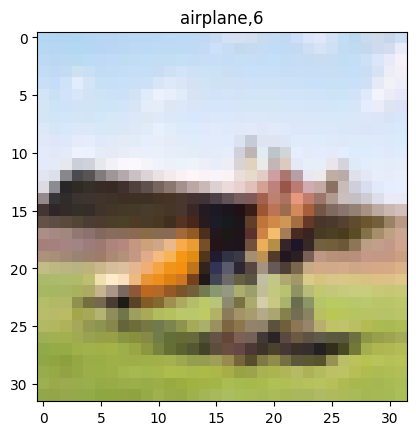

In [ ]:
ylabel = [l for l in labels for fname in (path/f'train/{l}').ls()]
i = 30002
plt.imshow(torch.einsum('cij->ijc',X[i]))
plt.title(f'{ylabel[i]},{y[i]}')

-   그림이 너무 어려운데?
-   맞추기 힘들겠는데..

`-` dls를 만들자.

In [ ]:
ds1 = torch.utils.data.TensorDataset(X,y)
ds2 = torch.utils.data.TensorDataset(XX,yy)
dl1 = torch.utils.data.DataLoader(ds1,batch_size=256,shuffle=True)
dl2 = torch.utils.data.DataLoader(ds2,batch_size=10000)
dls = DataLoaders(dl1,dl2)

`-` 아래와 같이 쉽게 만들수도있음…

In [ ]:
# dls = ImageDataLoaders.from_folder(path,train='train',valid='test') 1주차 강의에서 썼던 trick
# dls.show_batch()

## B. 수제네트워크로 학습

`-` 시도1: 이게 좀 힘들어요 ㅎㅎ

In [ ]:
# Step1:
ds1 = torch.utils.data.TensorDataset(X,y)
ds2 = torch.utils.data.TensorDataset(XX,yy)
dl1 = torch.utils.data.DataLoader(ds1,batch_size=64)
dl2 = torch.utils.data.DataLoader(ds2,batch_size=10000)
dls = DataLoaders(dl1,dl2)
# Step2:
net1 = torch.nn.Sequential(
    torch.nn.Conv2d(3,16,(5,5)), #색상이미지라서 입력 채널 3
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten()
)
net2 = torch.nn.Sequential(
    torch.nn.Linear(3136,10), #컨닝 가능.
)
net = torch.nn.Sequential(
    net1, # 2d-part
    net2, # 1d-part
)
loss_fn = torch.nn.CrossEntropyLoss()
lrnr = Learner(
    dls=dls,
    model=net,
    loss_func=loss_fn,
    #--#
    metrics=[accuracy]
)
# Step3:
lrnr.fit(10)
# Step4:
lrnr.model.to("cpu")
print(f'train: {(lrnr.model(X).data.argmax(axis=1) == y).float().mean():.4f}')
print(f'val: {(lrnr.model(XX).data.argmax(axis=1) == yy).float().mean():.4f}')

epoch,train_loss,valid_loss,accuracy,time
0,2.775095,2.306007,0.106100,00:05
1,2.231797,14.994980,0.100000,00:02
2,1.018309,36.106144,0.100000,00:03
3,1.147990,33.035732,0.100000,00:03
4,0.585428,47.530655,0.100000,00:03
5,0.411911,71.465523,0.100000,00:03
6,0.978831,34.487133,0.100000,00:03
7,2.135739,167.406616,0.100000,00:03
8,2.151753,219.607620,0.100000,00:03
9,3.046656,186.690002,0.100000,00:02


train: 0.1000
val: 0.1000


training loss는 감소하는 반면 validation loss가 증가함 -> 전형적인 overfitting

-   ????

`-` 시도2: 셔플!

shuffle의 기능,, 배치에 랜덤성을 줌으로써 학습의 성능을 올릴 수 있다.

In [ ]:
# Step1:
ds1 = torch.utils.data.TensorDataset(X,y)
ds2 = torch.utils.data.TensorDataset(XX,yy)
dl1 = torch.utils.data.DataLoader(ds1,batch_size=64,shuffle=True) #차이점..
dl2 = torch.utils.data.DataLoader(ds2,batch_size=10000)
dls = DataLoaders(dl1,dl2)
# Step2:
net1 = torch.nn.Sequential(
    torch.nn.Conv2d(3,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten()
)
net2 = torch.nn.Sequential(
    torch.nn.Linear(3136,10),
)
net = torch.nn.Sequential(
    net1, # 2d-part
    net2, # 1d-part
)
loss_fn = torch.nn.CrossEntropyLoss()
lrnr = Learner(
    dls=dls,
    model=net,
    loss_func=loss_fn,
    #--#
    metrics=[accuracy]
)
# Step3:
lrnr.fit(10)
# Step4:
lrnr.model.to("cpu")
print(f'train: {(lrnr.model(X).data.argmax(axis=1) == y).float().mean():.4f}')
print(f'val: {(lrnr.model(XX).data.argmax(axis=1) == yy).float().mean():.4f}')

epoch,train_loss,valid_loss,accuracy,time
0,1.420176,1.406097,0.496200,00:04
1,1.313963,1.326370,0.539600,00:02
2,1.213720,1.334156,0.538300,00:03
3,1.151039,1.205415,0.582900,00:03
4,1.124147,1.150168,0.595400,00:03
5,1.082004,1.145773,0.605400,00:03
6,1.066464,1.222896,0.563200,00:03
7,1.032109,1.119812,0.611600,00:03
8,1.024352,1.141748,0.603900,00:03
9,1.004562,1.094183,0.620000,00:03


train: 0.6810
val: 0.6200


-   셔플의 차이가 이렇게 크다니??

`-` 시도3: 복잡하게..

In [ ]:
# Step1:
ds1 = torch.utils.data.TensorDataset(X,y)
ds2 = torch.utils.data.TensorDataset(XX,yy)
dl1 = torch.utils.data.DataLoader(ds1,batch_size=64,shuffle=True)
dl2 = torch.utils.data.DataLoader(ds2,batch_size=10000)
dls = DataLoaders(dl1,dl2)
# Step2:
net1 = torch.nn.Sequential(
    torch.nn.Conv2d(3,256,(5,5)),
    torch.nn.ReLU(),
    torch.nn.Conv2d(256,64,(5,5)),
    torch.nn.ReLU(),
    torch.nn.Conv2d(64,16,(5,5)),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten()
)
net2 = torch.nn.Sequential(
    torch.nn.Linear(1600,10),
)
net = torch.nn.Sequential(
    net1, # 2d-part
    net2, # 1d-part
)
loss_fn = torch.nn.CrossEntropyLoss()
lrnr = Learner(
    dls=dls,
    model=net,
    loss_func=loss_fn,
    #--#
    metrics=[accuracy]
)
# Step3:
lrnr.fit(10)
# # Step4:
# lrnr.model.to("cpu")
# print(f'train: {(lrnr.model(X).data.argmax(axis=1) == y).float().mean():.4f}')
# print(f'val: {(lrnr.model(XX).data.argmax(axis=1) == yy).float().mean():.4f}')

epoch,train_loss,valid_loss,accuracy,time


OutOfMemoryError: CUDA out of memory. Tried to allocate 7.48 GiB. GPU 0 has a total capacity of 14.75 GiB of which 6.92 GiB is free. Process 14265 has 7.83 GiB memory in use. Of the allocated memory 7.61 GiB is allocated by PyTorch, and 63.05 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## C. TransferLearning으로 학습

`-` ResNet18을 다운로드

남이 만든 방법을 따와서 만드는걸 TransferLearning이라고 합니다

In [ ]:
net = torchvision.models.resnet18()
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

`-` 마지막의 레이어만 수정

(fc): Linear(in_features=512, out_features=1000, bias=True) 는 class를 1000개 분류하는 놈임.. 우리는 10개만 수정하면 됩니다.

In [ ]:
net.fc #이미 있는 network의 linear net..

Linear(in_features=512, out_features=1000, bias=True)

In [ ]:
net.fc = torch.nn.Linear(512,10) #덮어씌우기

`-` 학습해보자.

In [ ]:
# Step1:
ds1 = torch.utils.data.TensorDataset(X,y)
ds2 = torch.utils.data.TensorDataset(XX,yy)
dl1 = torch.utils.data.DataLoader(ds1,batch_size=64,shuffle=True)
dl2 = torch.utils.data.DataLoader(ds2,batch_size=10000)
# Step2:
net = torchvision.models.resnet18() #트랜스퍼 러닝.. 레스넷 받고
net.fc = torch.nn.Linear(512,10) #마지막 레이어만 우리가 관심있는 10개 따리로 변경
loss_fn = torch.nn.CrossEntropyLoss()
lrnr = Learner(
    dls=dls,
    model=net,
    loss_func=loss_fn,
    #--#
    metrics=[accuracy]
)
# Step3:
lrnr.fit(10)
# # Step4:
# lrnr.model.to("cpu")
# print(f'train: {(lrnr.model(X).data.argmax(axis=1) == y).float().mean():.4f}')
# print(f'val: {(lrnr.model(XX).data.argmax(axis=1) == yy).float().mean():.4f}')

epoch,train_loss,valid_loss,accuracy,time
0,1.182091,1.323778,0.548500,00:18
1,0.961879,1.148879,0.609800,00:17
2,0.792236,0.975325,0.659400,00:17
3,0.682816,0.883130,0.701000,00:18
4,0.568002,0.795920,0.729300,00:18
5,0.480410,0.846010,0.730900,00:17
6,0.431198,0.811770,0.743700,00:18
7,0.361677,0.888384,0.731800,00:17
8,0.305248,0.842275,0.746100,00:18
9,0.229249,0.964660,0.747500,00:18


> **Caution**
>
> 통계학과서버를 이용하시는 분들은 다른 학생들을 위하여 실습이 끝난이후
> 커널을 죽여주시기 바랍니다. 그렇지 않으면 GPU메모리 부족으로
> 다른학생들이 실습할 수 없습니다. (무슨말인지 모르겠으면 저에게
> 물어보세요)

# 8. HW

Krizhevsky, Alex, Ilya Sutskever, and Geoffrey E Hinton. 2012. “Imagenet
Classification with Deep Convolutional Neural Networks.” *Advances in
Neural Information Processing Systems* 25.

옛날에 질문했던 finetune 은 기존의 가중치는 유지하고 우리가 지정한 부분만 가중치를 갱신하는 것임.fit은 다 적합하는 것임.